In [116]:
%load_ext autoreload
%autoreload 1
%aimport APDPkmeans
%aimport Fmeasure
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import APDPkmeans
import Fmeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load S1 normalizated dataset
data = pd.read_csv('../dataset/S1_normal.csv', names=['x','y'],sep=r'\s*,\s*',na_values="?",engine='python')
data = np.array(data)
print(data)

[[0.69308026 0.86133085]
 [0.16919891 0.57184644]
 [0.42787512 0.81894665]
 ...
 [0.36827631 0.57790645]
 [0.62463009 0.35493321]
 [0.3346573  0.17727468]]


SSE: 15.425222633450613


[]

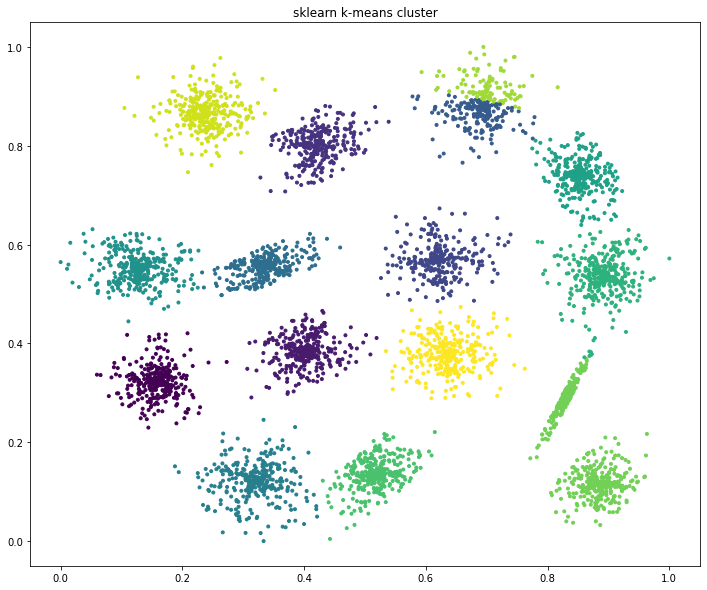

In [103]:
kmeans = KMeans(n_clusters=15,init='random')
kmeans.fit(data)
kmeans_sse=kmeans.inertia_
kmeans_clusters=kmeans.labels_
print('SSE:',kmeans_sse)
plt.figure(figsize=(12,10))
plt.title("sklearn k-means cluster")
plt.scatter(data[:, 0], data[:, 1], marker='.', c=kmeans_clusters)
plt.plot()

In [117]:
total_eps = [1, 2, 3, 4, 5, 6]
total_sse = []
total_clusters = []
total_f_measure = []
for eps in total_eps:
    apdpkmeans = APDPkmeans.APDPkmeans(data, n_clusters = 15, eps = eps)
    apdpk_sse = []
    clusters = []
    for i in range(10):
        cluster, sse = apdpkmeans.fit(show = False)
        apdpk_sse.append(sse)
        clusters.append(cluster)
    current_clusters = clusters[np.argmin(np.array(apdpk_sse))]
    total_f_measure.append(Fmeasure.fmeasure(kmeans_clusters, current_clusters, 5000, 15))
    total_sse.append(np.mean(apdpk_sse))

iters:  10
Uniform:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
iters:  10
Uniform:  [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
Training finished after 10 iterations!
iters:  10
Uniform:  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
Training finished after 10 iter

In [118]:
print(np.log(total_sse))
print(total_f_measure)

[6.68621159 6.33029845 6.02002788 6.07814647 5.73416852 5.7625778 ]
[0.7340596444977981, 0.7666975176776489, 0.8859486761312569, 0.9549195646132335, 0.8871363823237709, 0.9729534803413323]


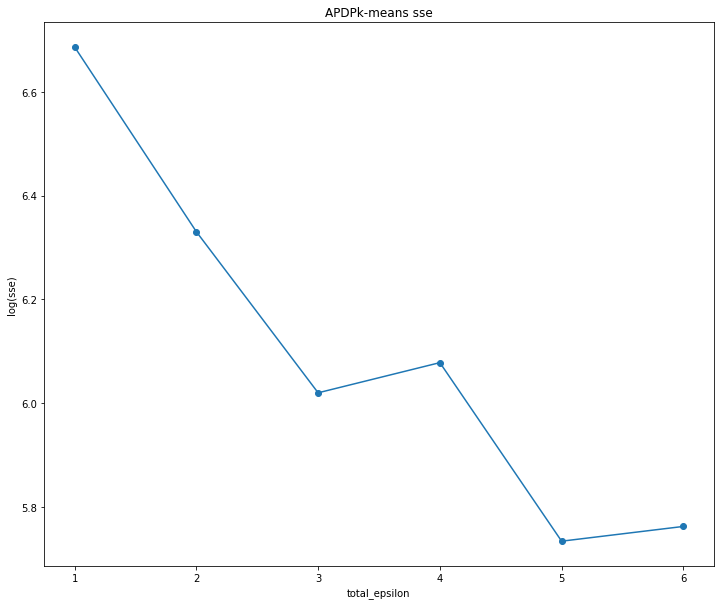

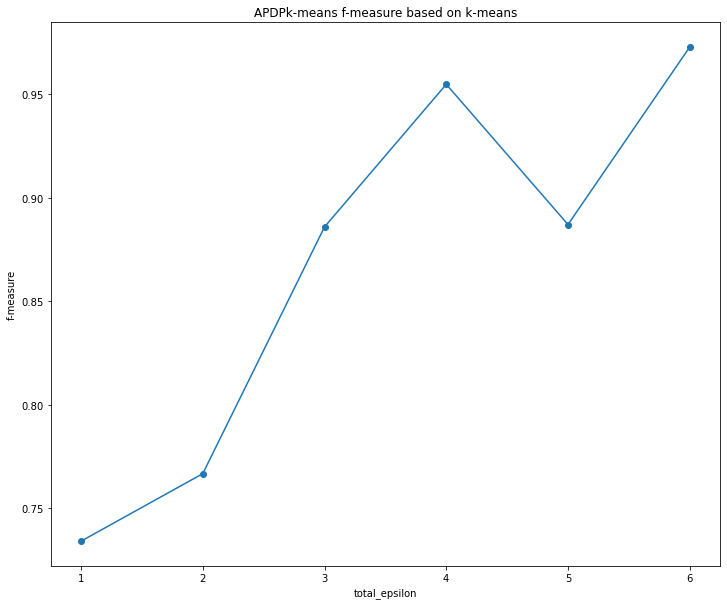

In [119]:
plt.figure(figsize=(12,10))
plt.title("APDPk-means sse")
plt.xlabel('total_epsilon')
plt.ylabel('log(sse)')
plt.plot(total_eps, np.log(total_sse), marker = 'o')

plt.figure(figsize=(12,10))
plt.title("APDPk-means f-measure based on k-means")
plt.xlabel('total_epsilon')
plt.ylabel('f-measure')
plt.plot(total_eps, total_f_measure, marker = 'o')